In [3]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StringIndexer, StandardScaler, OneHotEncoder
from pyspark.sql.functions import col
from pyspark.sql import functions as f
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

Ce modéle de ML estime les prix d'une voiture à partir de plusieurs caractéristiques

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .appName("SparkML") \
        .config("spark.some.config.option", "some-value")\
        .master("spark://0622870c1427:7077") \
        .config("spark.executor.memory", "3g") \
        .getOrCreate()

In [5]:
df2 = spark.read.option("header","true").option("delimiter",',').csv(r"../../data/archive-2")

In [6]:
# Columns with null values
df2.select([f.count(f.when(f.isnan(c)|f.col(c).isNull(),c)).alias(c) for c in df2.columns]).show()

+-----+------------+----+-----+------------+-------+--------+---+----+----------+
|model|manufacturer|year|price|transmission|mileage|fuelType|tax| mpg|engineSize|
+-----+------------+----+-----+------------+-------+--------+---+----+----------+
|    0|           0|   0|    0|           0|      0|       0|  0|9355|      9355|
+-----+------------+----+-----+------------+-------+--------+---+----+----------+



In [7]:
#Deleting the all null values
df2 = df2.na.drop()

In [8]:
# Here i am deleting some raws that are headers (error occured when i did a concat to my datasets)
df2 = df2.filter(col("model") != "model")

In [9]:
# Cast values to doubles
df2 = df2.withColumn("mileage", col("mileage").cast("double"))
df2 = df2.withColumn("tax", col("tax").cast("double"))
df2 = df2.withColumn("mpg", col("mpg").cast("double"))
df2 = df2.withColumn("engineSize", col("engineSize").cast("double"))
df2 = df2.withColumn("price", col("price").cast("double"))
df2 = df2.withColumn("year", col("year").cast("double"))

In [10]:
#String Indexer for String values

# Convert categorical features to numerical categories using StringIndexer
categorical_features = ["model", "manufacturer", "transmission", "fuelType"]
indexers = [StringIndexer(inputCol=cat_col, outputCol=cat_col+'_index') for cat_col in categorical_features]
models =[ index.fit(df2) for index in indexers]
for model in models:
    df2 = model.transform(df2)

In [11]:
# Prepare vecors of features
myData = df2["model_index","manufacturer_index" ,"transmission_index","fuelType_index","tax","mpg","year","mileage","price"]
# Assemble input features into a vector
assembler = VectorAssembler(inputCols=[ "model_index","manufacturer_index","transmission_index","fuelType_index","tax","year","mpg","mileage"], outputCol='features',handleInvalid="skip")

In [12]:
output = assembler.transform(myData)

In [13]:
output.show()

+-----------+------------------+------------------+--------------+-----+----+------+-------+-------+--------------------+
|model_index|manufacturer_index|transmission_index|fuelType_index|  tax| mpg|  year|mileage|  price|            features|
+-----------+------------------+------------------+--------------+-----+----+------+-------+-------+--------------------+
|        0.0|               0.0|               2.0|           0.0|150.0|57.7|2017.0|15944.0|12000.0|[0.0,0.0,2.0,0.0,...|
|        2.0|               0.0|               0.0|           0.0|150.0|57.7|2018.0| 9083.0|14000.0|[2.0,0.0,0.0,0.0,...|
|        2.0|               0.0|               0.0|           0.0|150.0|57.7|2017.0|12456.0|13000.0|[2.0,0.0,0.0,0.0,...|
|        0.0|               0.0|               0.0|           0.0|145.0|40.3|2019.0|10460.0|17500.0|(8,[4,5,6,7],[145...|
|        0.0|               0.0|               2.0|           0.0|145.0|48.7|2019.0| 1482.0|16500.0|[0.0,0.0,2.0,0.0,...|
|        0.0|           

In [14]:
#Normalize data with a MinMax Scaler 
scaler = MinMaxScaler(inputCol="features", outputCol="featuresNormalized")
# Compute summary statistics and generate MinMaxScalerModel
scalerModel = scaler.fit(output)

In [15]:
# rescale each feature to range [min, max].
scaledData = scalerModel.transform(output)

In [16]:
#print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
scaledData.select("features","featuresNormalized").show(truncate = False )

+--------------------------------------------+------------------------------------------------------------------------------------------------------------------+
|features                                    |featuresNormalized                                                                                                |
+--------------------------------------------+------------------------------------------------------------------------------------------------------------------+
|[0.0,0.0,2.0,0.0,150.0,2017.0,57.7,15944.0] |[0.0,0.0,0.6666666666666666,0.0,0.25862068965517243,0.5222222222222223,0.12199787460148778,0.049359285942061744]  |
|[2.0,0.0,0.0,0.0,150.0,2018.0,57.7,9083.0]  |[0.010309278350515464,0.0,0.0,0.0,0.25862068965517243,0.5333333333333333,0.12199787460148778,0.028117734110631922]|
|[2.0,0.0,0.0,0.0,150.0,2017.0,57.7,12456.0] |[0.010309278350515464,0.0,0.0,0.0,0.25862068965517243,0.5222222222222223,0.12199787460148778,0.03856049089935263] |
|(8,[4,5,6,7],[145.0,2019.0,

In [17]:
# Split my data (i am using seed to ensure that every time i test again i have the same dataset)
train_data, test_data = scaledData.randomSplit([0.7, 0.3], seed=1234)

#### Here i am trying to use LinearRegression to predict prices of cars, we will figure out later that linearRegression give us negatif values, which is not good since we are predicting prices
#### So we will need to try another type of regression which does not give negativ values

In [59]:
lr = LinearRegression(featuresCol="features", labelCol="price")

In [60]:
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.001, 0.01, 0.1])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

In [61]:
# Define evaluator
evaluator = RegressionEvaluator(metricName="rmse",labelCol = "price")

# Define cross-validator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Fit cross-validator to training data
cvModel = cv.fit(train_data)

# Make predictions on test data
predictions = cvModel.bestModel.transform(test_data)
# Evaluate performance on test data
rmse = evaluator.evaluate(predictions)

#### Plot predicted values and real ones to see 
#### Note that the blue ones are prdicted prices and  red ones are real prices

#### To evaluate this model i choosed to use the R-squared (the coefficient of determination)
#### This coeffeicent mean that x% of the variation of the price of a car is determined by all of those features and the rest are due to factors that are not in the model
#### RMSE is the off deviation between the real value and the  predicted one by the model, It indicates how spread out the data is around the line of best fit.


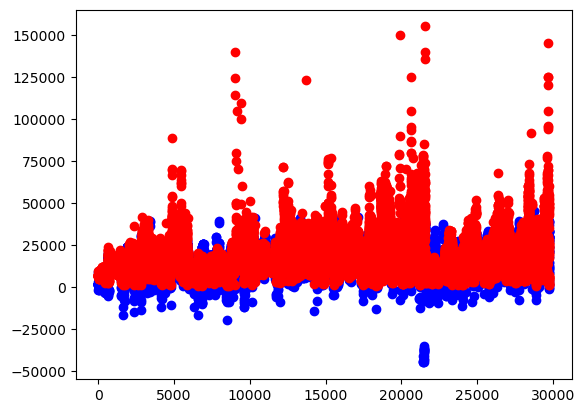

In [62]:
import matplotlib.pyplot as plt
import numpy as np

predicted = predictions.select('prediction')
real = predictions.select('price')

predicted =  np.array(predictions.select('prediction').collect())

real =  np.array(predictions.select('price').collect())

plt.scatter(range(len(predicted)), predicted, color='blue')
plt.scatter(range(len(real)), real, color='red')

plt.show()

In [63]:
differences =   real - predicted
mean_diff = np.mean(differences)
print(mean_diff)

61.11261634935515


In [64]:
# Evaluate the model using the R-squared metric
evaluator = RegressionEvaluator(metricName="r2",labelCol = "price")
r2 = evaluator.evaluate(predictions)

# Print the R-squared metric
print("R-squared = %g" % r2)

R-squared = 0.532371


In [65]:
test_data.count()

29749

In [66]:
# Evaluate the model using MSE
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(predictions)

# Print the MSE value
print("RMSE: ", mse)

RMSE:  6803.519355199761


In [67]:
#Here it is, we are trying the poissonRegression, this one will not give us negatif values


In [18]:
# Define the Poisson regression model
poisson_model = GeneralizedLinearRegression(family="poisson", link="log", maxIter=10, regParam=0.3,featuresCol = "features",labelCol = "price")


In [19]:
# Train the Poisson regression model
poisson_fit = poisson_model.fit(train_data)

In [20]:
predictions = poisson_fit.transform(test_data)

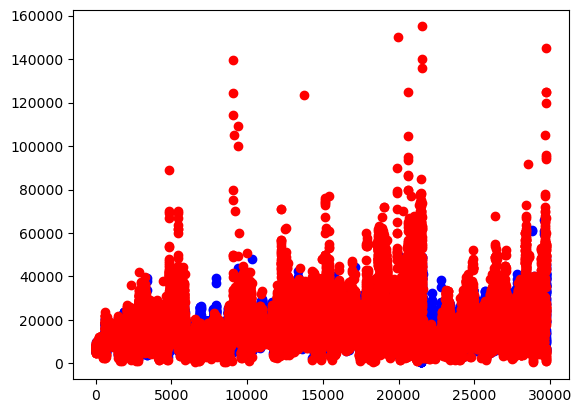

In [21]:
import matplotlib.pyplot as plt
import numpy as np

predicted = predictions.select('prediction')
real = predictions.select('price')

predicted =  np.array(predictions.select('prediction').collect())

real =  np.array(predictions.select('price').collect())

plt.scatter(range(len(predicted)), predicted, color='blue')
plt.scatter(range(len(real)), real, color='red')

plt.show()

In [22]:
# Evaluate the model using the R-squared metric
evaluator = RegressionEvaluator(metricName="r2",labelCol = "price")
r2 = evaluator.evaluate(predictions)

# Print the R-squared metric
print("R-squared = %g" % r2)

R-squared = 0.585025


In [23]:
# Evaluate the model using MSE
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(predictions)

# Print the MSE value
print("RMSE: ", mse)

RMSE:  6409.053186042661


In [24]:
differences =   real - predicted
mean_diff = np.mean(differences)
print(mean_diff)

44.92881541663


In [25]:
## Save the pickle file

In [32]:
cd

/home/jovyan


In [31]:

model_path = "../../src/mymodel.parquet"
poisson_fit.save(model_path)


In [1]:
### Create the pipeline and save the model

In [ ]:
pipeline = [categorical_features, indexers,models, myData, assembler, output, scaler, scalerModel, scaledData]